Simulate multiple models of students with varying noise and compare diligence estimates with each

# Setup

In [ ]:
import sys
sys.path.append("../lib")

In [2]:
import math
import random
import uuid
import os
import copy
import itertools
from collections.abc import Iterable
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import Bounds
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import pearsonr

from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import FactorAnalysis

from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

import statsmodels.api as sm



In [3]:
import logging

#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
#logging.basicConfig(level=logging.WARNING)

logger = logging.getLogger("main")

In [4]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [5]:
# from tutor.domain import Domain
from tutor.curriculum_factory import CurriculumFactory
from tutor.simple_curriculum import SimpleCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest

In [6]:
from learner.selfeff_learner import SelfEfficacyLearner
from learner.modular_learner import ModularLearner
from learner.cognition import *
from learner.decider import *

In [7]:
from simulate.modlearner_simulation import ModLearnerSimulation
from simulate.simulation import *
from simulate.script_helpers import SimHelper

In [8]:
from analytics.student_stats import *
from analytics.cae import *
from analytics.featurization import *
from analytics.batch import *
from analytics.step import *
from analytics.transaction import *
from analytics.session import *

In [9]:
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper
from log_db.learner_mapper import DBLearnerMapper

In [10]:
from CanonicalAutocorrelationAnalysis.model.caa import CAAComputation
from CanonicalAutocorrelationAnalysis.model.caaObject import *
from CanonicalAutocorrelationAnalysis.model.utils import l1Norm, l2Norm, r2Compute

In [11]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.info("Base directory for the project:\n%s" % base_dir)

INFO:analytics.session:Base directory for the project:
/rdata/Sandbox/MotivSim


In [12]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:analytics.session:Writing simulation results to directory: /rdata/Sandbox/MotivSim/test/data/sim-8b65ca41-70c4-460d-94e3-20bc1b9615d0
INFO:analytics.session:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': '27017', 'name': 'motivsim', 'user': '', 'pswd': ''}


In [13]:
# Test db connection
db_util.peak()

INFO:log_db.mongo:collection name, kcs, has 752 documents
INFO:log_db.mongo:collection name, caa_batches, has 0 documents
INFO:log_db.mongo:collection name, simbatches, has 4 documents
INFO:log_db.mongo:collection name, sessions, has 80000 documents
INFO:log_db.mongo:collection name, caa_models, has 0 documents
INFO:log_db.mongo:collection name, domains, has 1 documents
INFO:log_db.mongo:collection name, students, has 4000 documents
INFO:log_db.mongo:collection name, units, has 20 documents
INFO:log_db.mongo:collection name, decisions, has 14481275 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, steps, has 89141 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 4000 documents
INFO:log_db.mongo:collection name, problems, has 21258 documents
INFO:log_db.mongo:collection name, actions, has 14481275 documents
INFO:log_db.mongo:collection name, sections, has 86 documents
INFO:log_db.mongo:collection name, tutor_ev

In [14]:
clear_db = False
if clear_db:
    logger.info("Clearing database before starting new simulation")
    db_util.clear_db()
else:
    logger.info("Skipping Clearing database")

INFO:analytics.session:Skipping Clearing database


# Simulating learners

In [15]:
num_students = 20
num_sessions = 10

In [16]:
sim_helper = SimHelper(db)

In [17]:
def get_cog_params():
    ability = -2
    while (ability < -1) or (ability > 1):
        ability = np.random.normal(0, 0.6)
    return {"ability": ability}

def gen_students(num_students, domain, curric, 
                 cog_mod, cog_params, dec_mod, dec_params):
    stus = []
    for i in range(num_students):
        cp = cog_params()
        cog = cog_mod(domain, **cp)
        dp = dec_params()
        dec = dec_mod(**dp)
        decider = DiligentDecider(dec)
        stu = ModularLearner(domain, cog, decider)
        stus.append(stu)
        
    return stus

def simulate_students(curric, students, batch):    
    
    env = simpy.Environment()

    mastery_thres = 0.95
    m_ses_len = 45
    sd_ses_len = 8
    max_ses_len = 60
    sim_start = dt.datetime.now()

    mod = round(len(students) / 10)
#     mod = 1
    for i, stu in enumerate(students):
        if i % mod == 0:
            logger.info("Simulating student #%i" % i)
        # Create associated tutor
        tutor = SimpleTutor(curric, stu._id, mastery_thres)

        # Initialize simulation processes
        sim = SingleStudentSim(db, env, sim_start, stu, tutor,
                               num_sessions, m_ses_len, sd_ses_len, max_ses_len)
        batch.add_sim(sim)

        env.process(sim.run())

    env.run()
                
    logger.info("Inserting %i simulated students to db" % len(students))
    result = db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
    logger.info("Db insert success: %s" % result.acknowledged)

    logger.info("Inserting simulation batch to db")
    result = db.simbatches.insert_one(batch.to_dict())
    logger.info("Db insert success: %s" % result.acknowledged)

    return batch, students


In [18]:
new_curric = None
new_domain = None

In [19]:
def get_domain_params(params=None):
    if params is None:
        #params = [0.7 , 0.05, 0.05, 0.01, 0.15, 0.05, 0.3 , 0.1 , 0.5 , 0.02]
        params = [0.4 , 0.1, 0.1, 0.03, 0.1, 0.05, 0.1 , 0.05 , 0.1 , 0.07]
    param_keys = ['m_l0', 'sd_l0', 'm_l0_sd', 'sd_l0_sd', 'm_t',
                'sd_t', 'm_s','sd_s', 'm_g', 'sd_g']
    domain_params = {k:v for k,v in zip(param_keys, params)}
    return domain_params

def gen_test_curric(db, db_params):
    global new_curric, new_domain
    if new_curric is None:
        logger.info("Generating new curriculum")
        
        domain_params = get_domain_params()


        curric_params = {'num_units': 20,
                         'mean_sections': 4,
                         'stdev_sections': 2,
                         'mean_unit_kcs': 22,
                         'stdev_unit_kcs': 23,
                         'section_kcs_lambda': 6,
                         'mean_steps': 10,
                         'stdev_steps': 4,
                         'mean_prob_kcs': 6,
                         'stdev_prob_kcs': 3,
                         'num_practice': 100
                        }

        domain, curric = CurriculumFactory.gen_curriculum(domain_params, curric_params)
        db.domains.insert_one(domain.to_dict())
        db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])
        curric_util = DB_Curriculum_Mapper(db_params)
        curric_util.write_to_db(curric)
        
        new_curric = curric
        new_domain = domain

        return domain, curric
    else:
        logger.info("New curriculum already generated")
        return new_domain, new_curric

In [20]:
def get_sim_batch(desc):
    simbatch = db.simbatches.find_one({"desc": desc})
    if simbatch is None:
        logger.info("Generating new simulation. None found in db")

        # generate simualted data for test
        domain, curric = gen_test_curric(db, db_params)
        students = gen_students(num_students, domain, curric, 
                                cog_mod, get_cog_params, 
                                dec_mod, get_dec_params)   
        logger.info(f"Persisting {len(students)} initialized students to db")
        db.students.insert_many([stu.to_dict() for stu in students])
        batch = SimulationBatch(desc)
        simulate_students(curric, students, batch)    
        logger.info(f"Simulated {len(students)} in batch with id: {batch._id}")
    else:
        logger.info(f"Found simulation batch: {str(simbatch['desc'])}")
        lmapper = DBLearnerMapper(db)
        students = [lmapper.get_modlearner_from_db(sid) for sid in simbatch['student_ids']]
        batch = SimulationBatch.from_dict(simbatch)
        logger.info(f"Recovered {len(students)} students from batch with id: {batch._id}")
        
    return students, batch

## Simple Diligent students

In [21]:
sim_batch_desc = "Simple diligent students"
cog_mod = BiasSkillCognition
dec_mod = EVDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    ability = random.triangular(-1,1)
    #logger.info(f"Generating student with ability: {ability}")
    return {'ability': ability}

def get_dec_params():
    return {}

In [22]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Found simulation batch: Simple diligent students
INFO:analytics.session:Recovered 1000 students from batch with id: 099a3859-2958-49af-b653-8db8a15640b3


## Self Efficacy Diligent students

In [23]:
sim_batch_desc = "Self-Efficacy students"
cog_mod = BiasSkillCognition
dec_mod = DomainSelfEffDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    se = -1
    while (se <= 0) or (se >1):
        se = random.gauss(0.5, 0.2)
    return {'attr': {'self_eff': se}}

In [24]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Found simulation batch: Self-Efficacy students
INFO:analytics.session:Recovered 1000 students from batch with id: f809ad6b-ae77-4280-b99f-aab5c0f4b543


## Intrinsic Interest Diligent students

In [25]:
sim_batch_desc = "Intrinsic Interest students"
cog_mod = BiasSkillCognition
dec_mod = MathInterestDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    return {'attr': {'interest': np.random.normal(0,1)}}

In [26]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Found simulation batch: Intrinsic Interest students
INFO:analytics.session:Recovered 1000 students from batch with id: 98712048-13de-4cbf-ba88-ad9aa6adc885


## Self-eff/Interest Diligent students

In [27]:
sim_batch_desc = "Combo students"
cog_mod = BiasSkillCognition
dec_mod = MathIntSelfEffDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    se = -1
    while (se <= 0) or (se >1):
        se = random.gauss(0.5, 0.2)
    return {'attr': {'self_eff': se, 'interest': np.random.normal(0,1)}}

In [28]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Found simulation batch: Combo students
INFO:analytics.session:Recovered 1000 students from batch with id: 9bd9cff5-da81-4ce3-9cb8-af2d74bbfe7f


# Estimating Diligence

Estimators to compare
1. Frequency of Off-task
2. Total Time 
3. Start Speed (procrastination)
4. Early Finish (persistence)
5. 2 Measure
6. 3 Measure
7. 4 Measure
8. Diligence & Cog Measures
4. M4: Multiple Diligence Measures
5. M5: Multiple Diligence & Multiple Cognitive Measure instrument
6: M6: Multiple diligence & Cog measures + CAE measures.

Seed Model

* Measures of Cognition
    * AFM intercept
    * Total Skills mastered

* Measures of Diligence
    * Total Time  
    * Frequency of Off-task
    * Start Speed
    * Early Finish



## Helpers

In [36]:
def get_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


In [37]:
def get_tx_fields(sids, fields=None):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, "type": "TutorInput"}))
    # Add kc field that reduces list of kcs to 1 kc
    tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)
    if fields is None:
        return tx
    else:
        return tx.loc[:, fields]

In [38]:
def get_tx(sids):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, 'type': "TutorInput"}))
    tx.index = tx['_id']
    tx['kc'] = tx.explode('kcs')['kcs'].apply(lambda x: x['_id'])
    return tx

def lbl_nondil_tx(tx):
    detector = Detector(db) 
    gt_lblr = TransactionAnnotator(db)
    
    kc_long_tx = detector.get_kc_long_cutoff(tx)
    kc_short_tx = detector.get_kc_short_cutoff(tx)

    # Add Ground truth labels (using global db var)

    tx['is_offtask'] = gt_lblr.label_offtask_tx(tx)
    tx['is_guess'] = gt_lblr.label_guess_tx(tx)

    # Add detector labels
    tx['detect_offtask'] = detector.is_off_task(tx, kc_stats=kc_long_tx)
    tx['detect_guess'] = detector.is_guess(tx, kc_stats=kc_short_tx)
    return tx
    


In [39]:
def calc_accuracy(tx_stats):
    d =  tx_stats['Correct']/ tx_stats['Total Tx']
    d.rename("accuracy", inplace=True)
    return d

def calc_err_on_1_opp(tx):
    d = tx[tx['attempt'] == 0]
    # Get 1st opportunity
    cols = [col for col in d.columns if col not in ['stu_id', 'kc']]
    opp1 = d.groupby(['stu_id', 'kc']).apply(lambda x: x.iloc[0][cols]).reset_index()
    opp1['is_correct'] = opp1['outcome'] == "Correct"
    ## Calculate P(Correct) per student
    opp1 =  opp1.groupby('stu_id')['is_correct'].apply(lambda x: np.sum(x) / len(x))
    opp1.rename("err_on_1_opp", inplace=True)
    return opp1

def calc_avg_prac_opp(tx, mastery_thres=0.9):
    # Get the learner knowledge at the end of each practice step
    d = tx.groupby(['stu_id', 'kc', 'step_id'])['plt1'].apply(lambda x: x[-1]).reset_index()
    d['has_mastered'] = d['plt1'] >= mastery_thres
    # Getting student-kc pairings for analysis
    stu_kc = d.loc[d['has_mastered'], ['stu_id','kc']].drop_duplicates()
    # Get just tx for relevant stu-kc's
    d = pd.merge(tx, stu_kc, on=['stu_id', 'kc'], how='inner')
    d = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
    d = d.groupby('stu_id')['step_id'].mean()
    d.rename('avg_prac_opp', inplace=True)
    return d

def calc_p_guess(tx):
    d = tx.groupby('stu_id')['detect_guess'].apply(lambda x: np.sum(x) / len(x))
    d.rename("p_guess", inplace=True)
    return d

def calc_detected_offtask(tx):
    if "detect_offtask" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_offtask'].mean()

    d.rename("mean_detect_offtask", inplace=True)
    return d

def calc_detected_guess(tx):
    if "detect_guess" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_guess'].mean()

    d.rename("mean_detect_guess", inplace=True)
    return d

def calc_time_on_task(tx):
    d = tx.pivot_table(index="stu_id", columns="is_offtask", values="duration", fill_value=0, aggfunc=np.sum).reset_index()
    d.index = d['stu_id']
    d.rename(columns={False: "time_on_task", True: "time_off_task"}, inplace=True)
    d.drop(columns=['stu_id'], inplace=True)
    d['time_on_task'] = d['time_on_task'] / 3600
    d['time_off_task'] = d['time_off_task'] / 3600
    return d

    
    


In [40]:
def get_student_sessions(sids):
    # Get login-logout transactions for students
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sid}, "type": {"$in": ["SessionStart", "SessionEnd"]}}))
    ses_ids = tx['session_id'].unique().tolist()
    # Append session metadata
    sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
    sessions.drop(columns=['type'], inplace=True)
    sessions.rename(columns={"_id": "session_id"}, inplace=True)
    tx = pd.merge(tx, sessions, on="session_id", how='inner')
    return tx

def calc_session_stats(sids):
    tx = get_student_sessions(sids)
    
    # Calc student-session stats
    session_stats = tx.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
    session_stats = pd.merge(tx.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

    # Start/end speed
    session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
    session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

    # session length
    session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
    session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
    session_stats['pct class'] = session_stats['session length'] / session_stats['class length']
    
    return session_stats

def calc_stu_session_stats(sids):
    session_stats = calc_session_stats(sids)
    stu_session_stats = session_stats.groupby('stu_id')['start speed', 'early finish', 'session length', 'pct class'].agg('mean', 'std')
    return stu_session_stats


def calc_student_dil_stats(sids):
    tx = get_tx(sid)
    tx = lbl_nondil_tx(tx)

    detect_offtask = calc_detected_offtask(tx)
    detect_guess = calc_detected_guess(tx)
    time_on_task = calc_time_on_task(tx)

    return pd.concat([detect_guess, detect_offtask, time_on_task], axis=1)



In [41]:
def calc_stats(ids):

    tx = get_tx(ids)
    tx = pd.concat([tx, tx_lblr.label_nondil_tx(tx)], axis=1)
    # Merge decisions with tx
    decisions, actions = tx_lblr.get_tx_decisions(tx)
    tx = tx_lblr.merge_decisions(tx, actions, decisions)
#     logger.info(f"Merged actions and decisions with tx: {tx['stu_id'].unique().shape}")

    # Get step rollup
    steps = step_calc.rollup_tx(tx)
    steps = pd.concat([steps, step_calc.label_knowledge(steps)], axis=1)
#     logger.info("Completed step rollup {steps['stu_id'].unique().shape}")
    

    # Calculate student non-diligent stats
#     logger.info(f"Number of students in tx: {tx['stu_id'].unique().shape}")
    detect_offtask = calc.calc_detected_offtask(tx)
#     logger.info(f"Detect offtask: {detect_offtask.shape}")
    detect_guess = calc.calc_detected_guess(tx)
    time_on_task = calc.calc_time_on_task(tx)
#     logger.info("Calculated off-task and diligence metrics")

    # Count opportunities at each knowledge level
    kc_prac = step_calc.count_practice_challenge(steps)
    over_prac = kc_prac.apply(lambda x: x['high_knowledge'] / np.sum(x), axis=1)
#     logger.info(f"Over Practice: {over_prac.shape}")
#     logger.info("Calculated kc practice stats")

    # Calculate work rate:
    work_rate = calc.calc_avg_work_rate(steps)
    # Calculate expected work time
    d = pd.DataFrame(db.kcs.find({"_id": {"$in": steps['kc'].tolist()}})).rename(columns={'_id': "kc"})
    steps = pd.merge(steps, d, on="kc", how="outer")
    steps['expected_duration'] = steps['Attempts'] * steps['m_time']
    exp_work_rate = steps.groupby('stu_id')['duration'].sum() / steps.groupby('stu_id')['expected_duration'].sum()
#     logger.info("exp_work_rate: {exp_work_rate.shape}")
#     logger.info("Calculated work rate stats")

    # Calculate hint usage by knowledge level
    stu_level_hints = steps.groupby(['stu_id', 'knowledge_level'])['Hint'].mean()
    #stu_level_hints.columns = [f"{col}-hints_used" for col in stu_level_hints.columns.tolist()]

    # Fit line for each student tendency to request hint
    

    
    # Calculate detector error
    # Plot Detector vs ground truth
    tx['offtask_tp'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == True)
    tx['offtask_fp'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == True)
    tx['offtask_tn'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == False)
    tx['offtask_fn'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == False)
    tx['guess_tp'] = (tx['is_guess'] == True) & (tx['detect_guess'] == True)
    tx['guess_fp'] = (tx['is_guess'] == False) & (tx['detect_guess'] == True)
    tx['guess_tn'] = (tx['is_guess'] == False) & (tx['detect_guess'] == False)
    tx['guess_fn'] = (tx['is_guess'] == True) & (tx['detect_guess'] == False)
    

    ot_err = tx.groupby('stu_id')[['offtask_tp', 'offtask_fp', 'offtask_tn', 'offtask_fn']].sum()

    g_err = tx.groupby('stu_id')[['guess_tp', 'guess_fp', 'guess_tn', 'guess_fn']].sum()
#     logger.info("Calculated detector error counts")

#     total_stats = {}
#     total_stats['ot_tp'] = np.sum(tx['offtask_tp']) / tx.shape[0]
#     total_stats['ot_fp'] = np.sum(tx['offtask_fp']) / tx.shape[0]
#     total_stats['ot_tn'] = np.sum(tx['offtask_tn']) / tx.shape[0]
#     total_stats['ot_fn'] = np.sum(tx['offtask_fn']) / tx.shape[0]



#     total_stats['g_tp'] = np.sum(tx['guess_tp']) / tx.shape[0]
#     total_stats['g_fp'] = np.sum(tx['guess_fp']) / tx.shape[0]
#     total_stats['g_tn'] = np.sum(tx['guess_tn']) / tx.shape[0]
#     total_stats['g_fn'] = np.sum(tx['guess_fn']) / tx.shape[0]
#     det_err[desc] = total_stats

    stats = pd.concat([detect_offtask, detect_guess, time_on_task, kc_prac, 
                         over_prac, work_rate, exp_work_rate, ot_err, g_err], axis=1)
#     logger.info(f"Merged stats: {stats.shape}")
    return stats


## Calculate Stats

In [42]:
# Calculating stats with analytic methods

calc = StudentStatCalc(db)
batch_calc = BatchCalculator()
detector = Detector(db)
tx_lblr = TransactionAnnotator(db)
step_calc = StepCalculator(db)
tx_calc = TransactionCalculator(db)
session_calc = SessionCalculator(db)

In [43]:
# Get students batches
batches = [batch for batch in db.simbatches.find()]
batch_descs = ["Simple diligent students",
               "Self-Efficacy students",
               "Intrinsic Interest students",
               "Combo students"
              ]
sids = {desc: [] for desc in batch_descs}
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \nID: {batch['_id']}\ndesc: {batch['desc']}")
    if batch['desc'] in batch_descs:
        logger.info(f"recovered {len(batch['student_ids'])} student ids for batch {batch['desc']}")
        sids[batch['desc']].append(batch['student_ids'])

INFO:analytics.session:batch #0: 
ID: 099a3859-2958-49af-b653-8db8a15640b3
desc: Simple diligent students
INFO:analytics.session:recovered 1000 student ids for batch Simple diligent students
INFO:analytics.session:batch #1: 
ID: f809ad6b-ae77-4280-b99f-aab5c0f4b543
desc: Self-Efficacy students
INFO:analytics.session:recovered 1000 student ids for batch Self-Efficacy students
INFO:analytics.session:batch #2: 
ID: 98712048-13de-4cbf-ba88-ad9aa6adc885
desc: Intrinsic Interest students
INFO:analytics.session:recovered 1000 student ids for batch Intrinsic Interest students
INFO:analytics.session:batch #3: 
ID: 9bd9cff5-da81-4ce3-9cb8-af2d74bbfe7f
desc: Combo students
INFO:analytics.session:recovered 1000 student ids for batch Combo students


In [44]:

stu_stats = {desc: {} for desc in batch_descs}
mastery_thres = 0.9
stu_prob_stats = {desc: {} for desc in batch_descs}
kc_stats = {desc: {} for desc in batch_descs}
det_err = {desc: {} for desc in batch_descs}
logger.info("Starting calculation")
for desc in batch_descs:

    # Temporarily use only the first 100 out of 1000 students for speed of analysis
    sid = sids[desc][0][:100]
    logger.info(f"EDA of {len(sid)} students for batch, {desc}")

    logger.info(f"Calculating for student set:\t{desc}")
    args = [get_stu_parameters, sid, 50, [mastery_thres]]
    sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

    args = [calc.get_action_counts, sid, 50]
    action_dist, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

    args = [calc.total_tx_stats, sid, 50]
    tx_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")


    args = [session_calc.calc_stu_session_stats, sid, 50]
    ses_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student activity stats: {ses_stats.shape}\tRuntime: {runtime} seconds")

    args = [calc_stats, sid, 50]
    dil_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated diligence stats: {dil_stats.shape}\tRuntime: {runtime} seconds")


    stu_stats[desc] = pd.concat([sim_students, action_dist, tx_stats, ses_stats, 
                                 dil_stats], axis=1)
    logger.info(f"Merged new stats together: {stu_stats[desc].shape}")


INFO:analytics.session:Starting calculation
INFO:analytics.session:EDA of 100 students for batch, Simple diligent students
INFO:analytics.session:Calculating for student set:	Simple diligent students
INFO:analytics.session:Calculated student params: (100, 20)	Runtime: 0.227506 seconds
INFO:analytics.session:Calculated student action stats: (100, 13)	Runtime: 32.985455 seconds
INFO:analytics.session:Calculated student activity stats: (100, 9)	Runtime: 42.920707 seconds
INFO:analytics.session:Calculated student activity stats: (100, 5)	Runtime: 19.862582 seconds
INFO:analytics.session:Calculated diligence stats: (100, 20)	Runtime: 220.698971 seconds
INFO:analytics.session:Merged new stats together: (100, 67)
INFO:analytics.session:EDA of 100 students for batch, Self-Efficacy students
INFO:analytics.session:Calculating for student set:	Self-Efficacy students
INFO:analytics.session:Calculated student params: (100, 20)	Runtime: 0.311225 seconds
INFO:analytics.session:Calculated student acti

## Compare Estimators

### M1: Freq of Off-task

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Correlation with Diligence: R = 0.008220518292826898	 pval = 0.935304355219713
INFO:analytics.session:Correlation with Diligence: R = -0.49711727266828026	 pval = 1.4315267302903427e-07
INFO:analytics.session:Correlation with Cog Ability: R = -0.05138061503773291	 pval = 0.611676465748698
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Correlation with Diligence: R = -0.14512892889553508	 pval = 0.1496744051283015
INFO:analytics.session:Correlation with Diligence: R = -0.501421960883227	 pval = 1.0726889317162373e-07
INFO:analytics.session:Correlation with Cog Ability: R = -0.031500601493096164	 pval = 0.7557072449174251
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:Correlation with Diligence: R = -0.19151156473390116	 pval = 0.05629495464746259
INFO:analytics.session:Correlation with Diligence: R = 

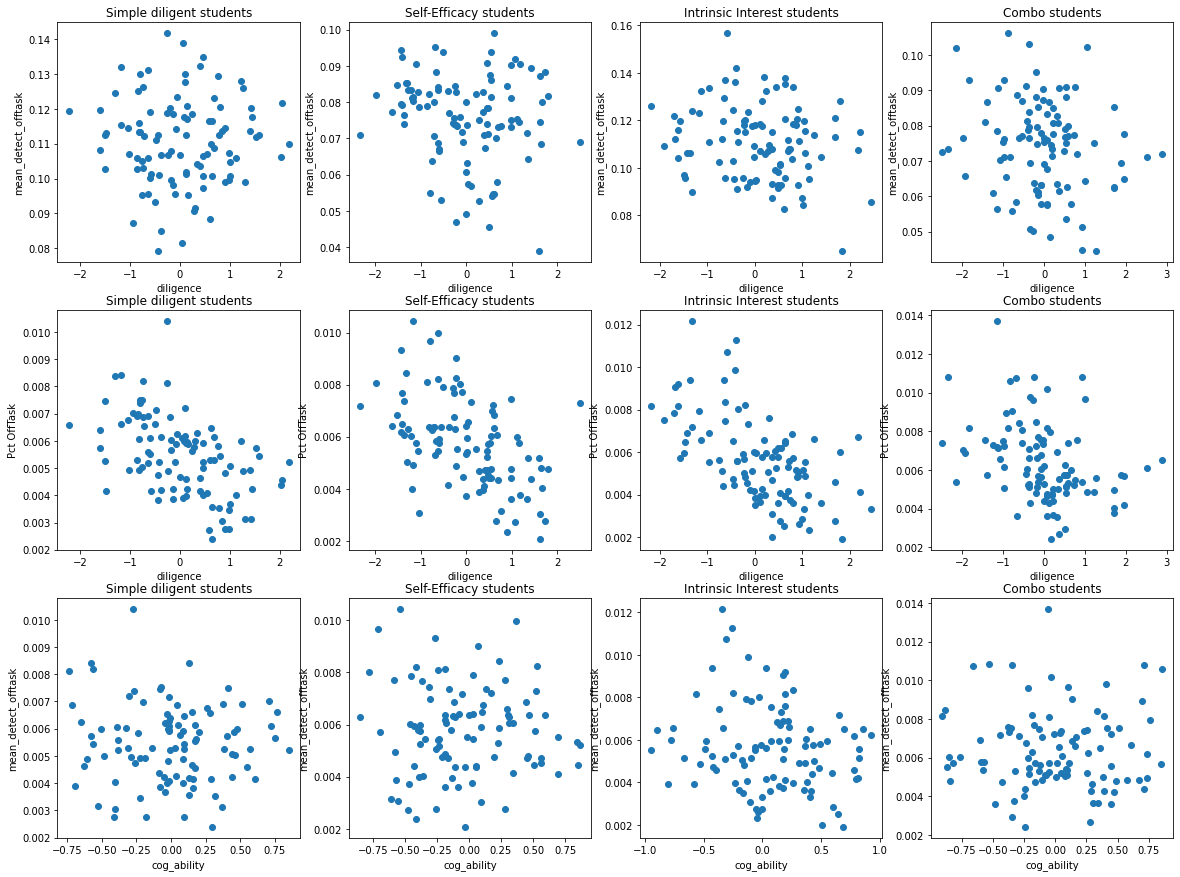

In [54]:
n = len(batch_descs)
plt.figure(figsize=(5*n,15))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]

    xcol = "diligence"
    ycol = "mean_detect_offtask"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "diligence"
    ycol = "Pct OffTask"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    ycol = "mean_detect_offtask"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,2*n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M2: Total Time

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Correlation with Diligence: R = 0.5774481360106115	 pval = 3.186642814705436e-10
INFO:analytics.session:Correlation with Cog Ability: R = -0.09479035113847753	 pval = 0.3481927714356788
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Correlation with Diligence: R = 0.39200914373868245	 pval = 5.4956142275572915e-05
INFO:analytics.session:Correlation with Cog Ability: R = -0.12721202643704396	 pval = 0.20721599835540058
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:Correlation with Diligence: R = 0.48731914941447413	 pval = 2.7210003652503065e-07
INFO:analytics.session:Correlation with Cog Ability: R = 0.047483136918784016	 pval = 0.6389793461151551
INFO:analytics.session:Comparing student sim: Combo students
INFO:analytics.session:Correlation with Diligence: R = 0.40963691170031263	 pval = 2.31483727

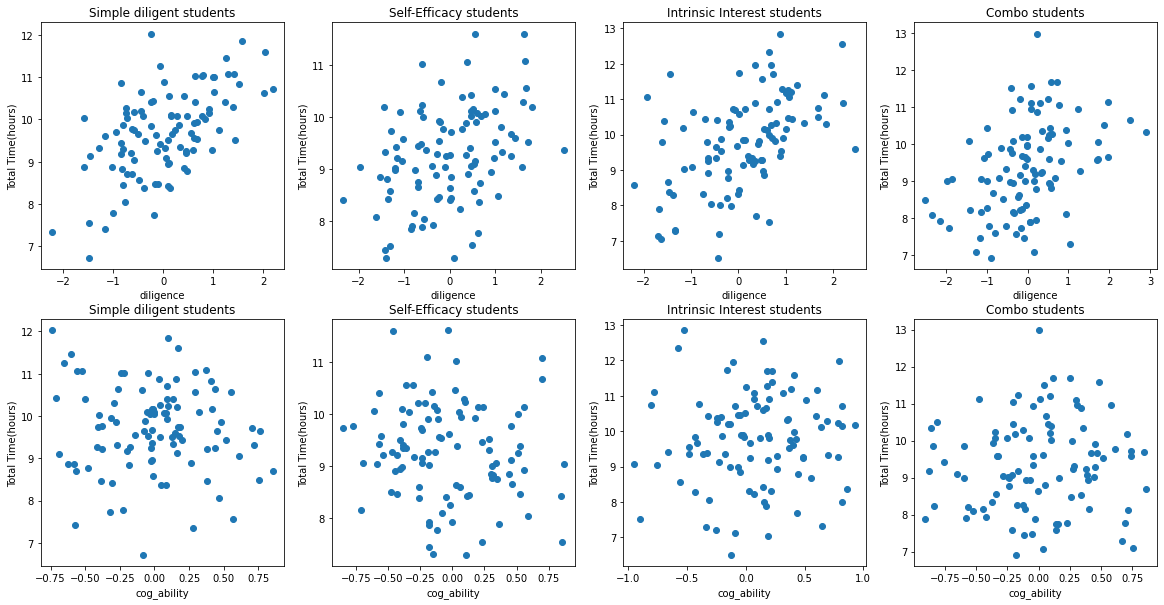

In [46]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "Total Time(hours)"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M3: Time-on-task

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:R = 0.6168327564651238	 pval = 8.295873569475548e-12
INFO:analytics.session:Correlation with Cog Ability: R = -0.25218505338090436	 pval = 0.01136741222242247
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:R = 0.4069070769425585	 pval = 2.6549901237397285e-05
INFO:analytics.session:Correlation with Cog Ability: R = -0.15163664308328223	 pval = 0.13206070123870295
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:R = 0.42811904168504694	 pval = 8.861238694601677e-06
INFO:analytics.session:Correlation with Cog Ability: R = -0.11176830325568834	 pval = 0.26824896743529497
INFO:analytics.session:Comparing student sim: Combo students
INFO:analytics.session:R = 0.24943123533357175	 pval = 0.012326978576416688
INFO:analytics.session:Correlation with Cog Ability: R = -0.04407007553391232	 pval = 0.6632926617040

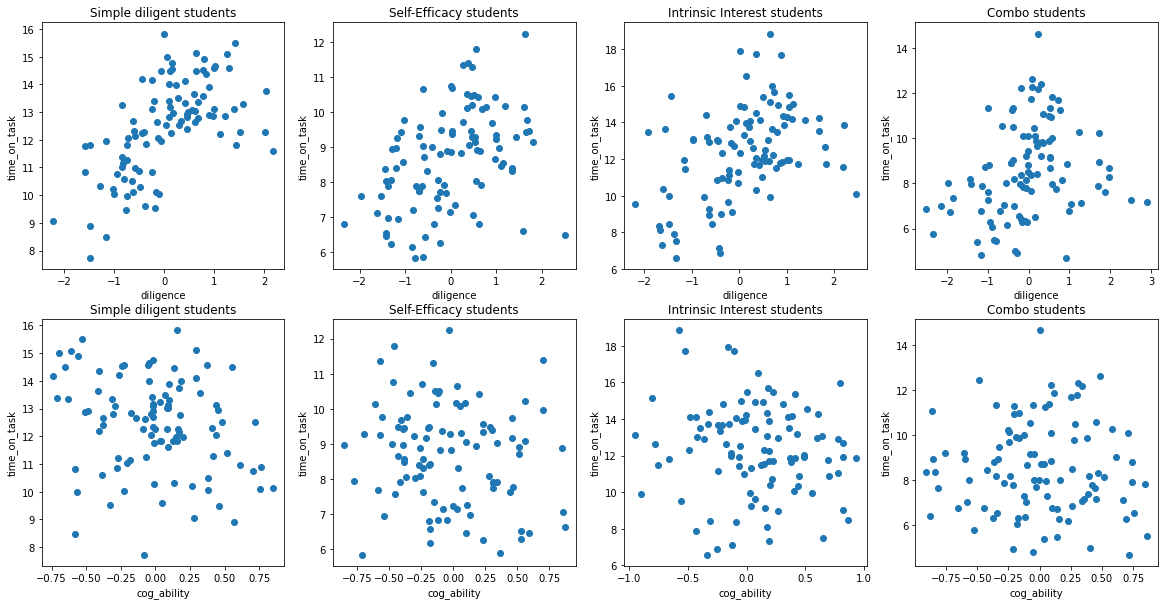

In [47]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "time_on_task"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M4: Start Speed

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:R = -0.8587792106347332	 pval = 3.213665534580974e-30
INFO:analytics.session:Correlation with Cog Ability: R = 0.09521222269481366	 pval = 0.3460418239701426
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:R = -0.8408477811788934	 pval = 7.1353985494473095e-28
INFO:analytics.session:Correlation with Cog Ability: R = -0.10658839496484504	 pval = 0.29119970719931404
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:R = -0.5152297647436134	 pval = 4.1364751220836415e-08
INFO:analytics.session:Correlation with Cog Ability: R = -0.010310472413922127	 pval = 0.9189065869515461
INFO:analytics.session:Comparing student sim: Combo students
INFO:analytics.session:R = -0.41208575278427445	 pval = 2.044863383763258e-05
INFO:analytics.session:Correlation with Cog Ability: R = 0.03692778111200175	 pval = 0.71529091901

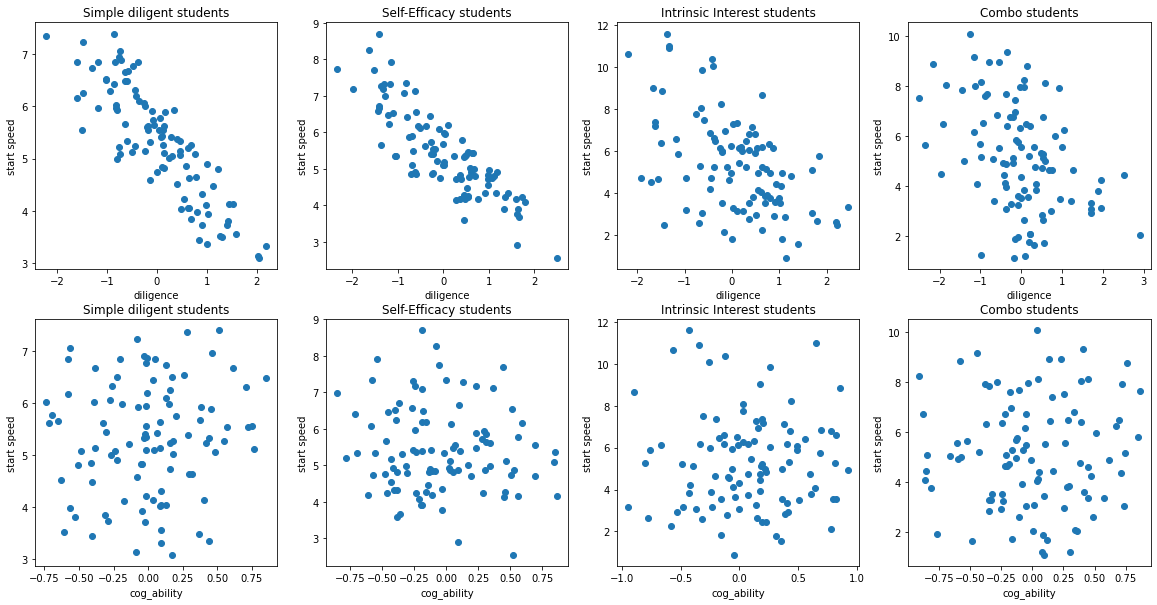

In [56]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "start speed"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M5: Early Finish

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:R = -0.26022180505923725	 pval = 0.008930290360198755
INFO:analytics.session:Correlation with Cog Ability: R = 0.06489709783160519	 pval = 0.5212053194820724
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:R = -0.19781360115402058	 pval = 0.04851762454575633
INFO:analytics.session:Correlation with Cog Ability: R = 0.1246984018048415	 pval = 0.21640740389206467
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:R = -0.3499822359369596	 pval = 0.00035779645409894433
INFO:analytics.session:Correlation with Cog Ability: R = -0.08607267766132236	 pval = 0.3944988737451051
INFO:analytics.session:Comparing student sim: Combo students
INFO:analytics.session:R = -0.3549993544019927	 pval = 0.0002899123671308534
INFO:analytics.session:Correlation with Cog Ability: R = -0.19195131245016056	 pval = 0.0557209892497218

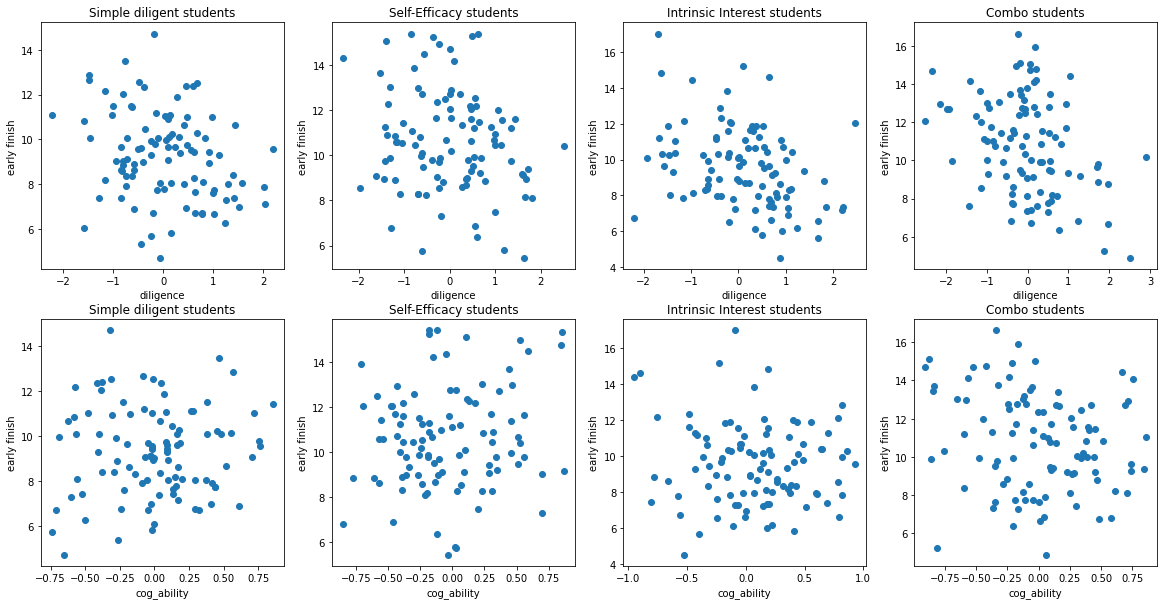

In [57]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "early finish"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

##### M4: Multi-Diligence Measures

INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4468091736868845
INFO:analytics.session:EigenValues: [2.05957918 1.02052568 0.7539058  0.16598934]
INFO:analytics.session:Factor Loadings: [[-1.02691485]
 [-0.03113682]
 [ 0.50088019]
 [ 0.66912968]]
INFO:analytics.session:Factor Variance: (array([1.75413912]), array([0.43853478]), array([0.43853478]))
INFO:analytics.session:Factor loadings: Total Time(hours)     -1.026915
mean_detect_offtask   -0.031137
start speed            0.500880
early finish           0.669130
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.5695367027824947	 pval = 6.262450264798067e-10
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student si

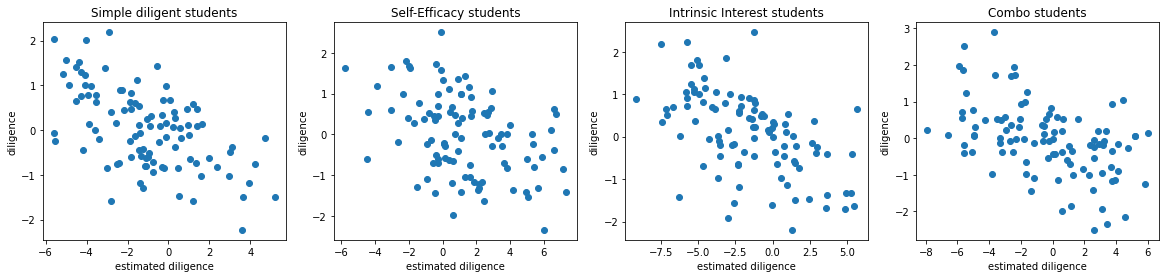

In [58]:
'''
Diligence Factors
    
1. Frequency of Off-task
2. Total Time 
3. Start Speed (procrastination)
4. Early Finish (persistence)

'''
n = len(batch_descs)
plt.figure(figsize=(5*n,4))

for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
#    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']
    dil_cols = ['Total Time(hours)', 'mean_detect_offtask', 'start speed', 'early finish']
    xcols= dil_cols
    ycol = "diligence"
    #Factor analysis
    df = ss.loc[:,xcols]
    kmo_all, kmo_model = calculate_kmo(df)
    logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
    fa = FactorAnalyzer(rotation=None,  n_factors=1)
    fa.fit(df)
    # Check Eigenvalues
    ev, v = fa.get_eigenvalues()
    logger.info(f"EigenValues: {ev}")
    logger.info(f"Factor Loadings: {fa.loadings_}")
    logger.info(f"Factor Variance: {fa.get_factor_variance()}")
    
    loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
    logger.info(f"Factor loadings: {loadings}")
    X = df.mul(loadings).apply('sum', axis=1)
    logger.info(X.shape)
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info("******************* Pearson ********************")
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(1,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel("estimated diligence")
    plt.ylabel(ycol)
plt.show()



##### M5: Multiple Dil & Cog Measures

In [49]:
def identify_dil_factor(w, key_col="mean_detect_offtask"):
    abs_w = w.apply(lambda x: abs(x))
    return abs_w.idxmax(axis=1)[key_col]
    
def identify_nondil_factor(w, key_col="mean_detect_offtask"):
    abs_w = w.apply(lambda x: abs(x))
    idxmax = abs_w.idxmax(axis=1)[key_col]
    col = None
    for i, col in enumerate(w.columns):
        if i != idxmax:
            return i

    

In [50]:
'''
Cognitive Factors
    Accuracy
    P(error | opp = 1) over all kc's
    E[P(mastery = k | kc)]
    Total Skills mastered
    
Diligence Factors
    
    Time in system
    Frequency of Off-task
    P(guess)
    
'''
n = len(batch_descs)
plt.figure(figsize=(10, 5*n))

for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']
    # cog_cols = ['final-sim total mastery', 'err_on_1_opp']
    dil_cols = ['Total Time(hours)', 'mean_detect_offtask', 'mean_detect_guess']
    xcols= cog_cols + dil_cols
    ycol = "diligence"
    #Factor analysis
    df = ss.loc[:,xcols]
    kmo_all, kmo_model = calculate_kmo(df)
    logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
    fa = FactorAnalyzer(rotation=None,  n_factors=2)
    fa.fit(df)
    # Check Eigenvalues
    ev, v = fa.get_eigenvalues()
    logger.info(f"EigenValues: {ev}")
    logger.info(f"Factor Loadings: {fa.loadings_}")
    logger.info(f"Factor Variance: {fa.get_factor_variance()}")
    
    all_loadings = pd.DataFrame(fa.loadings_, index=df.columns)
    dil_col = identify_dil_factor(all_loadings)

    for j, col in enumerate(all_loadings.columns):
        loadings = all_loadings.loc[:,col]
        logger.info(f"Factor loadings #{i}: {loadings}")
        X = df.mul(loadings).apply('sum', axis=1)
        logger.info(X.shape)
        if j == dil_col:
            ycol = 'diligence'
        else:
            ycol = "cog_ability"
        Y = ss[ycol]
        corr, pval = pearsonr(X,Y)
        logger.info(f"******************* Pearson with {ycol} ********************")
        logger.info(f"R = {corr}\t pval = {pval}")

        plt.subplot(n,2,(2*i) + j+1)
        plt.scatter(X, Y)
        plt.title(f"{desc}-factor_{col}")
        plt.xlabel("estimated factor")
        plt.ylabel(ycol)
plt.show()



INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['accuracy', 'err_on_1_opp', 'avg_prac_opp'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

<Figure size 720x1440 with 0 Axes>

##### M6: Multiple Dil & Cog Measures + CAE 

In [ ]:
Notes:
    
    - Could use AFM to estimate initial cog ability
    - Consider other confounders (self-eff or math-int) other than cog_ability
    -- Useful to show strenght of correlation with factor and ability of method to differentiate confounds